In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np

import scienceplots
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png',}

import pandas as pd
from pprint import pprint

pd.set_option('display.max_rows', 128)
pd.set_option('display.max_columns', 128)

plt.rcdefaults()

def mean_percentage_error(A, F):
    top = np.abs(A - F)
    bottom = np.maximum(np.maximum(np.abs(A), np.abs(F)), np.finfo(float).eps)
    return 100.0 * np.mean(top / bottom)

# UCIML

In [2]:
df = pd.read_parquet('../../data/uciml-dataset-hourly.complete.parquet')
prediction_target = 'global_active_power'


from pprint import pprint

domain_features = {
    #'PVs': [],
    #'EVs': [],
    'measurements': sorted([
        name for name in df.columns
        if ('power' in name) or ('meter' in name) or ('volt' in name) or ('intensity' in name)
    ])
}
print('\n== Domain Specific Features ==')
pprint(domain_features)

contextual_features = {
    'geolocation': ['lat', 'lon', 'region', 'country'],
    'time': [name for name in df.columns if name.startswith('year_') or name.startswith('day_') or name.startswith('week_')] + ['timestamp', 'tz', 'is_dst'],
    'weather_conditions': [name for name in df.columns if name.startswith('solar_')],
}
print('\n== Contextual Features ==')
pprint(contextual_features)

behavioral_features = {
    'social_activities': ['weekday', 'is_holiday', 'is_weekend'],
    'cooking': ['kitchen_activity'],
    'work_schedule': [
        'yesterday_ratio', 'yesterday_ratio_ahead', 'last_week_ratio', 'last_week_ratio_ahead', 'yesterday_median_energy', 'house_activity',
        'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17',
    ],
}
print('\n== Behavioral Features ==')
pprint(behavioral_features)

obtained_features = (
    [x for v in domain_features.values() for x in v] +
    [x for v in contextual_features.values() for x in v] +
    [x for v in behavioral_features.values() for x in v] +
    #["tz", 'region', "country", "timestamp"] + # useless in our case because it is constant
    ['prediction_1h_ahead', 'prediction_3h_ahead',]
)

# Check for missed features #1, #2, and duplicates
print(
    set(df.columns) - set(obtained_features), set(obtained_features) - set(df.columns), set([x for x in obtained_features if obtained_features.count(x) > 1])
)

domain_features = [x for v in domain_features.values() for x in v]
contextual_features = [x for v in contextual_features.values() for x in v]
behavioral_features = [x for v in behavioral_features.values() for x in v]


== Domain Specific Features ==
{'measurements': ['global_active_power',
                  'global_active_power_last_week',
                  'global_active_power_last_week_ahead',
                  'global_active_power_mean_3h',
                  'global_active_power_std_3h',
                  'global_active_power_yesterday',
                  'global_active_power_yesterday_ahead',
                  'global_intensity',
                  'global_intensity_last_week',
                  'global_intensity_last_week_ahead',
                  'global_intensity_mean_3h',
                  'global_intensity_std_3h',
                  'global_intensity_yesterday',
                  'global_intensity_yesterday_ahead',
                  'global_reactive_power',
                  'global_reactive_power_last_week',
                  'global_reactive_power_last_week_ahead',
                  'global_reactive_power_mean_3h',
                  'global_reactive_power_std_3h',
                  'global

In [3]:
import torch
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import NBEATSModel, NHiTSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from darts.utils.likelihood_models import QuantileRegression


used_features = []

#used_features = ['global_active_power', 'global_intensity', 'sub_metering_1', 'sub_metering_2', 'sub_metering_3', 'unmetered', 'voltage']

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features


for col in ('region', 'tz', 'country', 'timestamp', prediction_target):
    if col in used_features:
        used_features.remove(col)
        
# Remove data collected from submeters
keywords = ('meter', 'volt', 'kitchen', 'breakfast', 'dinner', 'lunch', 'sleep', 'work', 'freetime',)
for keyword in keywords:
    used_features = list(filter(lambda x: keyword not in x, used_features))


mapper = make_column_transformer(
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['category', 'object'])),
    remainder='passthrough',
    n_jobs=8,
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')


_df = df.copy()
_df.timestamp = _df.timestamp.dt.tz_convert('UTC').dt.tz_localize(None)


dfp = _df[['timestamp', prediction_target, *used_features]].copy().dropna().reset_index(drop=True)

dfp_train, dfp_test = train_test_split(dfp, train_size=0.8, shuffle=False)

mapper.fit(dfp_train)
dfp_train = mapper.transform(dfp_train)
dfp_test = mapper.transform(dfp_test)

_used_features = list(filter(lambda x: x not in ['timestamp'], mapper.get_feature_names_out()))

series_train = TimeSeries.from_dataframe(
    dfp_train, time_col='timestamp', value_cols=_used_features, fill_missing_dates=False, fillna_value=None, freq='H'
)
_series_train = MissingValuesFiller(n_jobs=8).transform(series_train)

series_test = TimeSeries.from_dataframe(
    dfp_test, time_col='timestamp', value_cols=_used_features, freq='H',
)
_series_test = MissingValuesFiller(n_jobs=8).transform(series_test)


kwargs = dict(
    optimizer_kwargs={"lr": 1e-4},
    #lr_scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau,
    #lr_scheduler_kwargs={'factor': 0.1, 'verbose': True, 'mode': 'min', 'patience': 4},
    force_reset=True,

    #
    batch_size=256,
    n_epochs=300,
    nr_epochs_val_period=1,

    loss_fn=torchmetrics.functional.mean_absolute_percentage_error,
    #loss_fn=torch.nn.MSELoss(),

    random_state=42,
    pl_trainer_kwargs=dict(
        accelerator='gpu', 
        devices=1, 
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, min_delta=5e-4, mode='min')
        ]
    ),
)

m = NBEATSModel(
    input_chunk_length=32, # was 32
    output_chunk_length=1,
    num_stacks=1,
    num_blocks=3,
    num_layers=3,
    layer_widths=512,
    dropout=0.1,
    **kwargs
)

m.fit(series=_series_train, val_series=_series_test, num_loader_workers=8, verbose=False)
prediction = m.predict(len(_series_test), verbose=False, n_jobs=8)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [4]:
from sklearn import metrics

def mean_percentage_error(A, F):
    A_abs, F_abs = np.abs(A), np.abs(F)
    mask = ~(np.maximum(A_abs, F_abs) == 0)
    return 100.0 * np.mean((np.abs(A - F) / np.maximum(A_abs, F_abs))[mask])

y_pred = prediction['global_active_power'].values()
y_test = series_test['global_active_power'].values()

# Mask: values unknown in ground truth | prediction is NaN | prediction is infinity
mask = ~(np.isnan(y_test))

y_pred = y_pred[mask]
y_test = y_test[mask]

mse = metrics.mean_squared_error(y_test, y_pred)
mpe = mean_percentage_error(y_test, y_pred)

print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-19 -- N-BEATS')

& 2.151 & 138.139  % 2023-04-19 -- N-BEATS


MSE = 0.622kWh
LogAcc = 0.010
MAPE = 75.726%
R2 = -0.09674
sMAPE = 62.827%
MAAPE = 57.325%
relative error = 45.780%
Carolina = 83.218%
Blaz = 27.821%


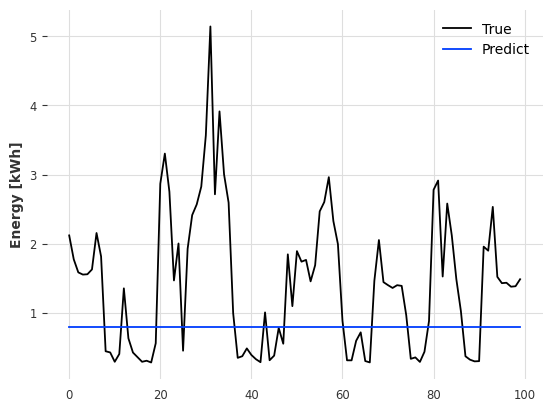

In [9]:
_y_true = y_test
_y_pred = y_pred

def sMAPE(A, F):
    return 100.0 / len(A) * np.sum(2 * np.abs(F - A) / np.maximum(np.abs(A) + np.abs(F), np.finfo(float).eps))

def log_accuracy(A, F):
    return np.mean(np.log(F / (A + np.finfo(float).eps)))

def mean_absolute_percentage_error(A, F):
    return 100.0 / len(A) * np.sum(np.abs(A - F) / np.maximum(A, 1e-6))

# MAAPE
def MAAPE(A, F):
    return 100.0 * np.mean(np.arctan(np.abs(A - F) / (A + np.finfo(float).eps)))

def relative_error(A, F):
    return 100.0 * np.mean(np.abs(A - F) / np.maximum(A, F))

def carolina_err_func(A, F):
    top = 1 + np.abs(A - F)
    bottom = 1 + np.abs(A)
    return 100.0  / len(A) * np.sum(top / bottom)


def blaz_err_func(A, F):
    return 100.0 * np.mean(np.abs(A - F) / (1 + np.abs(A)))

mape = mean_absolute_percentage_error(_y_true, _y_pred)
mse = metrics.mean_squared_error(_y_true, _y_pred)
r2 = metrics.r2_score(_y_true, _y_pred)
smape = sMAPE(_y_true, _y_pred)
log_acc = log_accuracy(_y_true, _y_pred)
rel_err = relative_error(_y_true, _y_pred)
maape = MAAPE(_y_true, _y_pred)
cfe = carolina_err_func(_y_true, _y_pred)
bb = blaz_err_func(_y_true, _y_pred)

print(
    f'MSE = {mse:,.3f}kWh\n'
    f'LogAcc = {log_acc:,.3f}\n'
    f'MAPE = {mape:,.3f}%\n'
    f'R2 = {r2:,.5f}\n'
    f'sMAPE = {smape:,.3f}%\n'
    f'MAAPE = {maape:,.3f}%\n'
    f'relative error = {rel_err:,.3f}%\n'
    f'Carolina = {cfe:,.3f}%\n'
    f'Blaz = {bb:,.3f}%'
)

plt.plot(_y_true[:100], label='True')
plt.plot(_y_pred[:100], label='Predict')
plt.ylabel('Energy [kWh]')
plt.legend()
plt.show()
#print(f'& {mse:,.3f}  & {mape:,.3f}  % 2023-04-17 -- N-HITS')

MSE = 0.622kWh
LogAcc = 0.010
MAPE = 75.726%
R2 = -0.09674
sMAPE = 62.827%
MAAPE = 57.325%
relative error = 45.780%
Carolina = 83.218%
Blaz = 27.821%


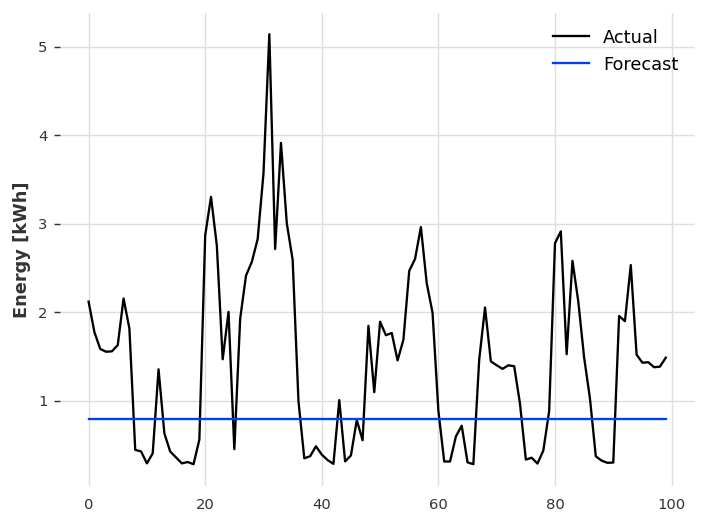

In [8]:
y_true = series_test['global_active_power'].values().squeeze()
y_true = y_true[~(np.isnan(y_true))]

y_pred = np.full_like(y_true, np.median(y_true))

#print(y_true.shape, y_pred.shape)
#print(y_pred)

# Mask: values unknown in ground truth | prediction is NaN | prediction is infinity
mask = ~(np.isnan(y_true) | np.isnan(y_pred) | np.isinf(y_pred))

_y_pred = y_pred[mask]
_y_true = y_true[mask]


mape = mean_absolute_percentage_error(_y_true, _y_pred)
mse = metrics.mean_squared_error(_y_true, _y_pred)
r2 = metrics.r2_score(_y_true, _y_pred)
smape = sMAPE(_y_true, y_pred)
log_acc = log_accuracy(_y_true, _y_pred)
rel_err = relative_error(_y_true, _y_pred)
maape = MAAPE(_y_true, _y_pred)
cfe = carolina_err_func(_y_true, _y_pred)
bb = blaz_err_func(_y_true, _y_pred)

print(
    f'MSE = {mse:,.3f}kWh\n'
    f'LogAcc = {log_acc:,.3f}\n'
    f'MAPE = {mape:,.3f}%\n'
    f'R2 = {r2:,.5f}\n'
    f'sMAPE = {smape:,.3f}%\n'
    f'MAAPE = {maape:,.3f}%\n'
    f'relative error = {rel_err:,.3f}%\n'
    f'Carolina = {cfe:,.3f}%\n'
    f'Blaz = {bb:,.3f}%'
)

plt.figure(dpi=128)
plt.plot(_y_true[:100], label='Actual')
plt.plot(_y_pred[:100], label='Forecast')
plt.ylabel('Energy [kWh]')
plt.legend()
plt.show()

# HUE dataset

In [4]:
from pprint import pprint

df = pd.read_parquet('../../data/hue-dataset-hourly.complete.parquet')
prediction_target = 'energy'

domain_features = {
    'EVs': ['EVs'],
    'measurements': [c for c in df.columns if c.startswith('energy')],
}
print('\n== Domain Specific Features ==')
pprint(domain_features)

contextual_features = {
    'geolocation': ['lat', 'lon', 'region', 'country', 'residential_id'],
    'time': [name for name in df.columns if name.startswith('year_') or name.startswith('day_') or name.startswith('week_')] + ['timestamp', 'tz', 'is_dst'],
    'weather_conditions': ['temperature', 'humidity', 'pressure', 'solar_altitude', 'solar_azimuth', 'solar_radiation'],
    'building_properties': ['house_type', 'facing'] + ['RUs', 'SN', 'FAGF', 'HP', 'FPG', 'FPE', 'IFRHG', 'NAC', 'FAC', 'PAC', 'BHE', 'IFRHE', 'WRHIR', 'GEOTH'],
}
print('\n== Contextual Features ==')
pprint(contextual_features)

behavioral_features = {
    'social_activities': ['weekday', 'is_holiday', 'is_weekend'],
    #'cooking': ['kitchen_activity'],
    'work_schedule': [
        'yesterday_ratio', 'yesterday_ratio_ahead', 'last_week_ratio', 'last_week_ratio_ahead', 'yesterday_median_energy', 'house_activity',
        'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17',
    ],
}
print('\n== Behavioral Features ==')
pprint(behavioral_features)


#domain_features = ['EVs'] + [c for c in df.columns if c.startswith('energy')]
#contextual_features = [
#    'residential_id', 'house_type', 'facing', 'region', 'RUs', 'SN', 'FAGF', 'HP', 'FPG', 'FPE', 'IFRHG',
#    'NAC', 'FAC', 'PAC', 'BHE', 'IFRHE', 'WRHIR', 'GEOTH', 'country', 'lat', 'lon', 'tz', 'temperature', 'humidity', 'pressure',
#    'day_percent', 'week_percent', 'year_percent', 'solar_altitude', 'solar_azimuth', 'solar_radiation'
#]
#behavioral_features = ['weekday', 'is_weekend', 'is_holiday', 'house_activity', 'yesterday_ratio', 'yesterday_ahead_ratio', 'last_week_ratio', 'last_week_ahead_ratio', 'yesterday_median_energy']

obtained_features = (
    [x for v in domain_features.values() for x in v] +
    [x for v in contextual_features.values() for x in v] +
    [x for v in behavioral_features.values() for x in v] +
    #["tz", 'region', "country", "timestamp"] + # useless in our case because it is constant
    ['prediction_1h_ahead', 'prediction_3h_ahead']
)

# Check for missed features #1, #2, and duplicates
print(set(df.columns) - set(obtained_features), set(obtained_features) - set(df.columns), set([x for x in obtained_features if obtained_features.count(x) > 1]))


domain_features = [x for v in domain_features.values() for x in v]
contextual_features = [x for v in contextual_features.values() for x in v]
behavioral_features = [x for v in behavioral_features.values() for x in v]


== Domain Specific Features ==
{'EVs': ['EVs'],
 'measurements': ['energy',
                  'energy_mean_3h',
                  'energy_std_3h',
                  'energy_yesterday',
                  'energy_yesterday_ahead',
                  'energy_last_week',
                  'energy_last_week_ahead']}

== Contextual Features ==
{'building_properties': ['house_type',
                         'facing',
                         'RUs',
                         'SN',
                         'FAGF',
                         'HP',
                         'FPG',
                         'FPE',
                         'IFRHG',
                         'NAC',
                         'FAC',
                         'PAC',
                         'BHE',
                         'IFRHE',
                         'WRHIR',
                         'GEOTH'],
 'geolocation': ['lat', 'lon', 'region', 'country', 'residential_id'],
 'time': ['day_percent',
          'week_percent',
        

In [27]:
import torch
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import NBEATSModel, NHiTSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from darts.utils.likelihood_models import QuantileRegression

used_features = []

#used_features = ['energy',]

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

for col in ('region', 'tz', 'country', 'timestamp', prediction_target):
    if col in used_features:
        used_features.remove(col)

mapper = make_column_transformer(
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['category', 'object'])),
    remainder='passthrough',
    n_jobs=8,
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')


_df = df.copy()
_df.timestamp = _df.timestamp.dt.tz_convert('UTC').dt.tz_localize(None)

y_pred, y_true = [], []





print(['timestamp', prediction_target, *used_features])

for idx, group in _df.groupby(by='residential_id'):

    if len(group) == 0: continue

    if idx not in (1, 2, 3, 4, 5, 6, 7):
        continue

    print(f'Samples  #{idx}: {len(group):,}')


    dfp = group[['timestamp', prediction_target, *used_features]].copy().dropna().reset_index(drop=True)

    dfp_train, dfp_test = train_test_split(dfp, train_size=0.8, shuffle=False)

    mapper.fit(dfp_train)
    dfp_train = mapper.transform(dfp_train)
    dfp_test = mapper.transform(dfp_test)

    _used_features = list(filter(lambda x: x not in ['timestamp'], mapper.get_feature_names_out()))

    series_train = TimeSeries.from_dataframe(
        dfp_train, time_col='timestamp', value_cols=_used_features, fill_missing_dates=False, fillna_value=None, freq='H'
    )
    _series_train = MissingValuesFiller(n_jobs=8).transform(series_train)

    series_test = TimeSeries.from_dataframe(
        dfp_test, time_col='timestamp', value_cols=_used_features, freq='H',
    )
    _series_test = MissingValuesFiller(n_jobs=8).transform(series_test)


    kwargs = dict(
        optimizer_kwargs={"lr": 1e-3},
        #lr_scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau,
        #lr_scheduler_kwargs={'factor': 0.1, 'verbose': True, 'mode': 'min', 'patience': 4},
        force_reset=True,

        batch_size=256,
        n_epochs=300,
        nr_epochs_val_period=1,

        loss_fn=torchmetrics.functional.mean_absolute_percentage_error,

        random_state=42,
        pl_trainer_kwargs=dict(
            accelerator='gpu', 
            devices=1, 
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, mode='min')
            ]
        ),
    )

    m = NBEATSModel(
        input_chunk_length=32,
        output_chunk_length=1,
        num_stacks=1,
        num_blocks=3,
        num_layers=3,
        layer_widths=512,
        dropout=0.1,
        **kwargs
    )

    m.fit(series=_series_train, val_series=_series_test, num_loader_workers=8, verbose=False)
    prediction = m.predict(len(_series_test), verbose=False, n_jobs=8)

    del m

    _y_pred = prediction[prediction_target].values()
    _y_true = _series_test[prediction_target].values()

    # Mask gap values in ground truth series
    #mask = ~np.isnan(_y_true)

    y_pred.append(_y_pred)
    y_true.append(_y_true)


['timestamp', 'energy', 'EVs', 'energy_mean_3h', 'energy_std_3h', 'energy_yesterday', 'energy_yesterday_ahead', 'energy_last_week', 'energy_last_week_ahead', 'lat', 'lon', 'residential_id', 'day_percent', 'week_percent', 'year_percent', 'is_dst', 'temperature', 'humidity', 'pressure', 'solar_altitude', 'solar_azimuth', 'solar_radiation', 'house_type', 'facing', 'RUs', 'SN', 'FAGF', 'HP', 'FPG', 'FPE', 'IFRHG', 'NAC', 'FAC', 'PAC', 'BHE', 'IFRHE', 'WRHIR', 'GEOTH', 'weekday', 'is_holiday', 'is_weekend', 'yesterday_ratio', 'yesterday_ratio_ahead', 'last_week_ratio', 'last_week_ratio_ahead', 'yesterday_median_energy', 'house_activity', 'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17']
Samples  #1: 29,230


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Samples  #2: 30,233


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Samples  #3: 26,376


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Samples  #4: 26,304


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Samples  #5: 26,304


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Samples  #6: 26,304


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [28]:
from sklearn import metrics

_y_true = np.concatenate(y_true, axis=0)
_y_pred = np.concatenate(y_pred, axis=0)

#mask = ~(np.isnan(_y_true) | np.isinf(_y_pred) | np.isnan(_y_pred) | np.isnan(_y_pred))

#_y_true = _y_true[mask]
#_y_pred = _y_pred[mask]

mse = metrics.mean_squared_error(_y_true, _y_pred)
mpe = mean_percentage_error(_y_true, _y_pred)

print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-20 -- N-BEATS')

& 0.887 & 77.877  % 2023-04-20 -- N-BEATS


# REFIT dataset

In [2]:
from pprint import pprint

df = pd.read_parquet('../../data/refit-dataset-hourly.complete.parquet')
prediction_target = 'energy'

domain_features = {
    'PVs': ['PVs'],
    'measurements': [c for c in df.columns if c.startswith('energy')] + [c for c in df.columns if c.startswith('appliance')],
}
print('\n== Domain Specific Features ==')
pprint(domain_features)

contextual_features = {
    'geolocation': ['lat', 'lon', 'country', 'house', 'location'],
    'time': [name for name in df.columns if name.startswith('year_') or name.startswith('day_') or name.startswith('week_')] + ['timestamp', 'tz', 'is_dst'],
    'weather_conditions': ['solar_altitude', 'solar_azimuth', 'solar_radiation'],
    'building_properties': ['house_type', 'house_size', 'occupancy', 'construction_year', 'n_appliances'],
}
print('\n== Contextual Features ==')
pprint(contextual_features)

behavioral_features = {
    'social_activities': ['weekday', 'is_holiday', 'is_weekend', 'bedroom', 'cooking', 'entertainment', 'cleaning', 'personal grooming', 'work at home'],
    '???': ['heating'],
    'work_schedule': [
        'yesterday_ratio', 'yesterday_ratio_ahead', 'yesterday_median_energy', 'last_week_ratio', 'last_week_ratio_ahead',
        'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17',
    ],
}
print('\n== Behavioral Features ==')
pprint(behavioral_features)

obtained_features = (
    [x for v in domain_features.values() for x in v] +
    [x for v in contextual_features.values() for x in v] +
    [x for v in behavioral_features.values() for x in v] +
    ['prediction_1h_ahead', 'prediction_3h_ahead']
)

# Check for missed features #1, #2, and duplicates
print(
    set(df.columns) - set(obtained_features), set(obtained_features) - set(df.columns), set([x for x in obtained_features if obtained_features.count(x) > 1])
)

domain_features = [x for v in domain_features.values() for x in v]
contextual_features = [x for v in contextual_features.values() for x in v]
behavioral_features = [x for v in behavioral_features.values() for x in v]


== Domain Specific Features ==
{'PVs': ['PVs'],
 'measurements': ['energy',
                  'energy_mean_3h',
                  'energy_std_3h',
                  'energy_yesterday',
                  'energy_yesterday_ahead',
                  'energy_last_week',
                  'energy_last_week_ahead',
                  'appliance1',
                  'appliance2',
                  'appliance3',
                  'appliance4',
                  'appliance5',
                  'appliance6',
                  'appliance7',
                  'appliance8',
                  'appliance9',
                  'appliance1_mean_3h',
                  'appliance1_std_3h',
                  'appliance2_mean_3h',
                  'appliance2_std_3h',
                  'appliance3_mean_3h',
                  'appliance3_std_3h',
                  'appliance4_mean_3h',
                  'appliance4_std_3h',
                  'appliance5_mean_3h',
                  'appliance5_std_3h',
     

In [10]:
import torch
import torchmetrics
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import NBEATSModel, NHiTSModel
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from darts.utils.likelihood_models import QuantileRegression

used_features = []

#used_features = ts_cols = [
#    'energy', 'appliance1', 'appliance2', 'appliance3', 'appliance4', 'appliance5',
#    'appliance6', 'appliance7', 'appliance8', 'appliance9',
#]


used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

for col in ('region', 'tz', 'country', 'timestamp', prediction_target):
    if col in used_features:
        used_features.remove(col)

# Exclude appliances, because for each house it's different (set of) device(s)
used_features = list(filter(lambda x: not x.startswith('appliance'), used_features))

# Remove data collected from submeters
submeter_related_columns = ['personal grooming', 'cooking', 'cleaning', 'entertainment', 'work at home', 'heating', 'PVs', 'bedroom', 'breakfast_6_9', 'lunch_11_15', 'dinner_18_21', 'sleep_22_7', 'work_9_17', 'freetime_17_22']
used_features = list(filter(lambda x: not x in submeter_related_columns, used_features))

mapper = make_column_transformer(
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['category', 'object'])),
    remainder='passthrough',
    n_jobs=8,
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')


_df = df.copy()
_df.timestamp = _df.timestamp.dt.tz_convert('UTC').dt.tz_localize(None)

y_pred, y_true = [], []



print(['timestamp', prediction_target, *used_features])

for idx, group in _df.groupby(by='house'):
    #continue

    #if len(group) == 0: continue

    print(f'House #{idx}: {len(group):,} samples')
    #continue
    if idx not in (1, 2, 3, 4, 5):
        continue


    dfp = group[['timestamp', prediction_target, *used_features]].copy().dropna().reset_index(drop=True)

    dfp_train, dfp_test = train_test_split(dfp, train_size=0.8, shuffle=False)

    mapper.fit(dfp_train)
    dfp_train = mapper.transform(dfp_train)
    dfp_test = mapper.transform(dfp_test)

    _used_features = list(filter(lambda x: x not in ['timestamp'], mapper.get_feature_names_out()))

    series_train = TimeSeries.from_dataframe(
        dfp_train, time_col='timestamp', value_cols=_used_features, fill_missing_dates=False, fillna_value=None, freq='H'
    )
    _series_train = MissingValuesFiller(n_jobs=8).transform(series_train)

    series_test = TimeSeries.from_dataframe(
        dfp_test, time_col='timestamp', value_cols=_used_features, freq='H',
    )
    _series_test = MissingValuesFiller(n_jobs=8).transform(series_test)

    kwargs = dict(
        optimizer_kwargs={"lr": 1e-3},
        #lr_scheduler_cls = torch.optim.lr_scheduler.ReduceLROnPlateau,
        #lr_scheduler_kwargs={'factor': 0.1, 'verbose': True, 'mode': 'min', 'patience': 4},
        force_reset=True,

        #
        batch_size=256,
        n_epochs=300,
        nr_epochs_val_period=1,

        loss_fn=torchmetrics.functional.mean_absolute_percentage_error,

        random_state=42,
        pl_trainer_kwargs=dict(
            accelerator='gpu', 
            devices=1, 
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, mode='min')
            ]
        ),
    )

    m = NBEATSModel(
        input_chunk_length=32,
        output_chunk_length=1,
        num_stacks=1,
        num_blocks=3,
        num_layers=3,
        layer_widths=512,
        dropout=0.1,
        **kwargs
    )

    m.fit(series=_series_train, val_series=_series_test, num_loader_workers=8, verbose=False)
    prediction = m.predict(len(_series_test), verbose=False, n_jobs=8)

    del m


    _y_pred = prediction[prediction_target].values()
    _y_true = _series_test[prediction_target].values()


    y_pred.append(_y_pred)
    y_true.append(_y_true)

['timestamp', 'energy', 'PVs', 'energy_mean_3h', 'energy_std_3h', 'energy_yesterday', 'energy_yesterday_ahead', 'energy_last_week', 'energy_last_week_ahead', 'appliance1', 'appliance2', 'appliance3', 'appliance4', 'appliance5', 'appliance6', 'appliance7', 'appliance8', 'appliance9', 'appliance1_mean_3h', 'appliance1_std_3h', 'appliance2_mean_3h', 'appliance2_std_3h', 'appliance3_mean_3h', 'appliance3_std_3h', 'appliance4_mean_3h', 'appliance4_std_3h', 'appliance5_mean_3h', 'appliance5_std_3h', 'appliance6_mean_3h', 'appliance6_std_3h', 'appliance7_mean_3h', 'appliance7_std_3h', 'appliance8_mean_3h', 'appliance8_std_3h', 'appliance9_mean_3h', 'appliance9_std_3h', 'lat', 'lon', 'house', 'location', 'day_percent', 'week_percent', 'year_percent', 'is_dst', 'solar_altitude', 'solar_azimuth', 'solar_radiation', 'house_type', 'house_size', 'occupancy', 'construction_year', 'n_appliances', 'weekday', 'is_holiday', 'is_weekend', 'bedroom', 'cooking', 'entertainment', 'cleaning', 'personal groom

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


House #2: 14,819 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


House #3: 14,752 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


House #4: 15,216 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


House #5: 15,561 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


House #6: 13,859 samples
House #7: 14,717 samples
House #8: 13,322 samples
House #9: 13,634 samples
House #10: 14,089 samples
House #11: 9,413 samples
House #12: 11,705 samples
House #13: 11,966 samples
House #15: 13,618 samples
House #16: 13,049 samples
House #17: 11,279 samples
House #18: 10,590 samples
House #19: 11,292 samples
House #20: 11,048 samples
House #21: 11,756 samples


In [12]:
from sklearn import metrics

_y_true = np.concatenate(y_true, axis=0)
_y_pred = np.concatenate(y_pred, axis=0)

#mask = ~(np.isnan(_y_true) | np.isinf(_y_pred) | np.isnan(_y_pred) | np.isnan(_y_pred))

#_y_true = _y_true[mask]
#_y_pred = _y_pred[mask]

mse = metrics.mean_squared_error(_y_true, _y_pred)
mpe = mean_percentage_error(_y_true, _y_pred)

print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-20 -- N-BEATS')

& 0.300 & 39.682  % 2023-04-20 -- N-BEATS


MSE=61.327; MAPE=0.596


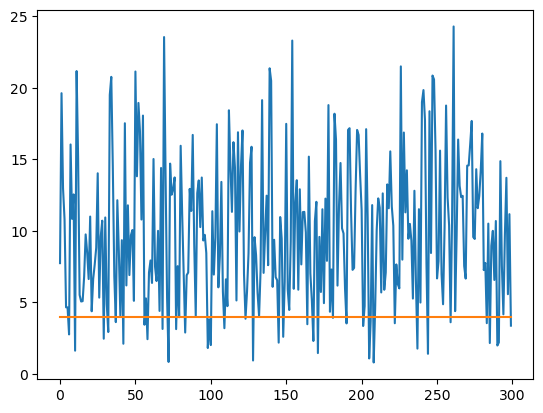

In [41]:
np.random.seed(42)

y_true = np.random.rayleigh(1.0, size=300) * 8
y_pred = np.full(300, 0.50) * 8

#y_true += 500
#y_pred += 500

plt.plot(y_true)
plt.plot(y_pred)


mape = metrics.mean_absolute_percentage_error(y_true , y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)

print(f'MSE={mse:,.3f}; MAPE={mape:,.3f}')

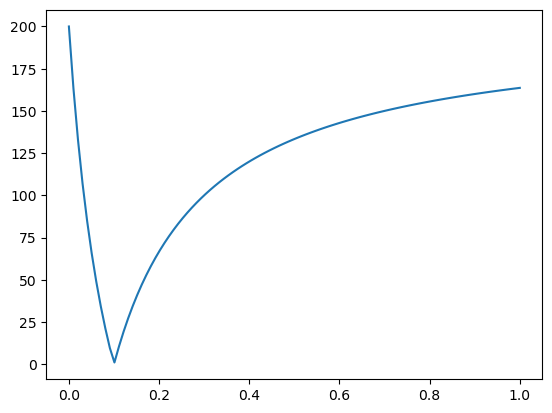

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Ideas for metrics
#def sMAPE(A, F):
#    return 100.0 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps))

x = np.linspace(0, 1, 100)
y = 0.1

z = 100 * 2 * np.abs(x - y) / (np.abs(x) + np.abs(y) + np.finfo(float).eps)

plt.plot(x, z)


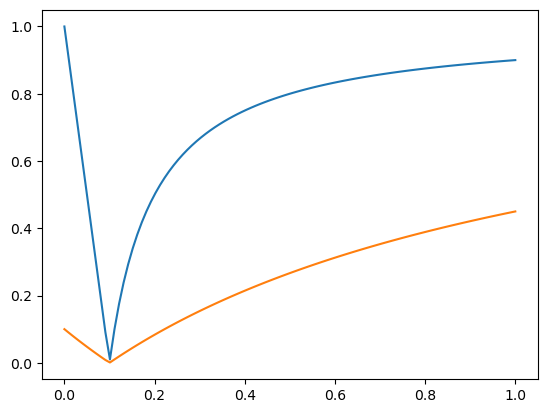

In [10]:
def relative_error_v1(y_true, y_pred):
    return np.abs(y_true - y_pred) / np.maximum(y_true, y_pred)

def relative_error_v2(y_true, y_pred):
    return np.abs(y_true - y_pred) / (1 + np.abs(y_true))

x = np.linspace(0, 1, 100)
y = 0.1

plt.plot(x, relative_error_v1(x, y))
plt.plot(x, relative_error_v2(x, y))

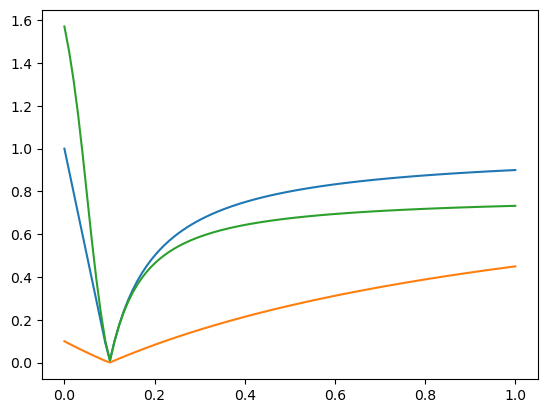

In [14]:
# MAAPE
def MAAPE(A, F):
    return 100.0 / len(A) * np.arctan(np.abs(A - F) / (A + np.finfo(float).eps))


x = np.linspace(0, 1, 100)
y = 0.1

plt.plot(x, relative_error_v1(x, y))
plt.plot(x, relative_error_v2(x, y))
plt.plot(x, MAAPE(x, y))